In [1]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data.dataset import Dataset
import timm
import pydicom as dicom
import cv2
from glob import glob
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.notebook import tqdm
from torch import nn


In [2]:
vertebrae_df = pd.read_csv('../input/rsna-2022-spine-fracture-detection-metadata/train_segmented.csv')
print(vertebrae_df.__len__())
vertebrae_df.head()

711601


,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.10001,1,512,512,0.625,-52.308,-27.712,7.282,0.005208,0.015055,0.003290,0.000895,0.001614,0.004632,0.002570
1,1.2.826.0.1.3680043.10001,2,512,512,0.625,-52.308,-27.712,6.657,0.005675,0.015945,0.002117,0.000562,0.001265,0.005648,0.004136
2,1.2.826.0.1.3680043.10001,3,512,512,0.625,-52.308,-27.712,6.032,0.006624,0.030292,0.003079,0.000677,0.000882,0.002238,0.002877
3,1.2.826.0.1.3680043.10001,4,512,512,0.625,-52.308,-27.712,5.407,0.006572,0.022294,0.003103,0.000975,0.001164,0.002434,0.002715
4,1.2.826.0.1.3680043.10001,5,512,512,0.625,-52.308,-27.712,4.782,0.004945,0.022388,0.003236,0.000826,0.000662,0.002304,0.006849


预测所有切片的骨折情况

In [8]:
def load_dicom(path):
    """
    This supports loading both regular and compressed JPEG images.
    See the first sell with `pip install` commands for the necessary dependencies
    """
    img=dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data=(data * 255).astype(np.float32)
    data = cv2.cvtColor(data, cv2.COLOR_GRAY2RGB)
    return data, img

class FracCLSDataset(Dataset):
    def __init__(self, img_path, transform=None):

        self.img_path = img_path
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None

    def __getitem__(self, index):

        img = load_dicom(self.img_path[index])[0]
        # img = img.astype(np.float32)
        # img = np.transpose(img, (2, 0, 1))

        if self.transform is not None:
            img = self.transform(image=img)['image']
        return img

    def __len__(self):
        return len(self.img_path)

def predict_frac(test_loader, model):
    model.eval()
    s = nn.Sigmoid()

    test_pred = []
    with torch.no_grad():
        # end = time.time()
        for i, (input) in enumerate(tqdm(test_loader)):
            input = input.cuda()

            # compute output
            output = model(input)
            test_pred.append(s(output.data.cpu()).detach().numpy())

    return np.vstack(test_pred)

In [4]:
paths = glob('../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.10051/*')
print(paths[:10])
df = pd.DataFrame(paths,columns=['path'])

['../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.10051\\1.dcm', '../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.10051\\10.dcm', '../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.10051\\100.dcm', '../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.10051\\101.dcm', '../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.10051\\102.dcm', '../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.10051\\103.dcm', '../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.10051\\104.dcm', '../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.10051\\105.dcm', '../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.10051\\106.dcm', '../input/rsna-2022-cervical-spine-fracture-detection/train_images

In [5]:
df.__len__()

272

In [9]:
model = torch.jit.load(r'W:\PycharmProjects\kaggle-RSNA\output\ckpt-CLS\p2_resnext_384_acc0.9839.pth')
model = model.to('cuda')
test_loader = torch.utils.data.DataLoader(
    FracCLSDataset(df['path'].values,
                  A.Compose([
                      A.Resize(height=384, width=384),
                      # A.CenterCrop(512,512),
                      # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                      ToTensorV2(),
                      ])
                  ), batch_size=8, shuffle=False, num_workers=0, pin_memory=False
)
pred = predict_frac(test_loader,model)


  0%|          | 0/34 [00:00<?, ?it/s]

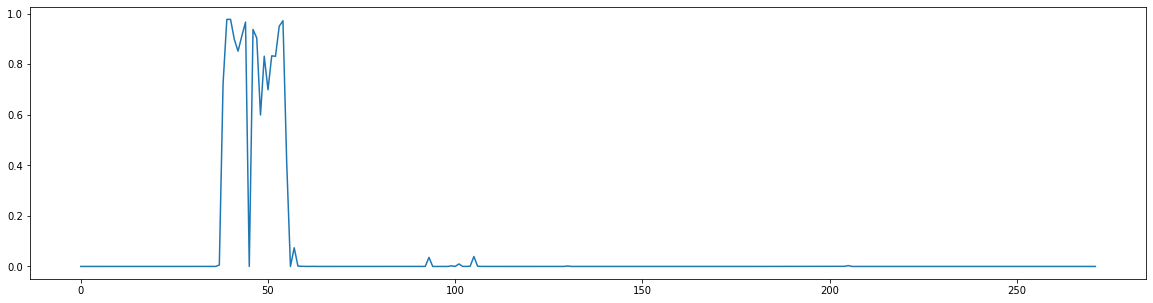

In [10]:
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)
plt.figure(figsize=(20, 5))
plt.plot(pred[:,0])